# **Biomedical Data Design**
## **Spring 2025 Capstone Project** - Isha Dev
This capstone project presents a data-driven web application for the automated detection of pediatric pneumonia using chest x-ray images. It features a custom CNN architecture trained to classify pediatric chest x-rays as `NORMAL` or `PNEUMONIA`.

This notebook contains data preprocessing, model architecture definition, model training, and evaluation on unseen data.

In [ ]:
!pip install -q medmnist
!pip install -q torchmetrics
!pip install -q torchviz
!pip install -q grad-cam
!pip install onnx
!pip install -q torchsummary

## Environment Setup
Import and install all essential Python packages necessary.

In [2]:
# Deep learning packages
import torch
import torch.nn as nn
from torch import utils
from torch import optim
from torch import device
from torch import inference_mode
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset, Subset, ConcatDataset
import torchvision
from torchvision import transforms
from torchmetrics import ConfusionMatrix
import torch.nn.functional as F
from torchviz import make_dot
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tqdm
from tqdm.auto import tqdm
from textwrap import wrap
from timeit import default_timer as timer
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import medmnist
from medmnist import INFO, Evaluator
from collections import Counter
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score,
                             roc_auc_score, roc_curve, recall_score, precision_recall_curve)
from tqdm import tqdm
import torchvision.models as models
from textwrap import wrap
from timeit import default_timer as timer
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import os
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

Mounted at /content/drive


## Dataset Preparation and Exploration
Load the dataset [Pediatric Chest X-ray Pneumonia](https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray), retrieve relevant dataset information, split it into training, validation, and test sets using stratified sampling to preserve class distribution, and prepare CSV summaries to keep track of dataset splits.

Define a pytorch `ChestXrayDataset` class to load images and labels from the CSV files and apply transforms. One set of transforms for the training data including data augmentation, and one set of transforms for validation/training data to rezise and normalize images.

Wrap the data splits using pytorch `DataLoader` to enable batch processing and shuffling.

In [3]:
# Maps string labels in CSV to integers
# Both viral and bacterial pneumonia are grouped into one class: 1
label_map = {'NORMAL': 0, 'PNEUMONIA-VIRAL': 1, 'PNEUMONIA-BACTERIAL': 1}
class_names = ['NORMAL', 'PNEUMONIA'] # Class name list and number of output classes
n_classes = len(class_names)
n_channels = 1  # Grayscale images
hidden_units = 128
IMG_SIZE = 224  # Inout image size

# Training transforms with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                # Resize
    transforms.RandomRotation(5),                           # Apply slight random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Vary brightness and contrast
    transforms.Grayscale(num_output_channels=1),            # Grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalize to range [-1, 1]
])

# Validation and Test transforms without data augmentation
eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                # Resize
    transforms.Grayscale(num_output_channels=1),            # Grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalize to range [-1, 1]
])

class ChestXrayDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        # Load CSV and store/transform
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        # Number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Get image filename and label string
        img_name = self.data.iloc[idx]['filename']
        label_str = self.data.iloc[idx]['label']
        # Map label to integer
        label = label_map[label_str]
        # Load image and convert to RGB
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

# Paths to images and labels
csv_path = '/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/labels.csv'
img_dir = '/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/all_images'

# Load dataset without transforms
full_dataset_for_split = ChestXrayDataset(csv_path, img_dir, transform=None)

# Extract all labels to stratify
labels = [label_map[label] for label in pd.read_csv(csv_path)['label']]

# Train/Val/Test Split (70/20/10)
train_idx, temp_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.3,
    stratify=labels,
    random_state=0
)
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.3333,
    stratify=temp_labels,
    random_state=0
)

# Reload datasets now with appropriate transforms
full_dataset_train = ChestXrayDataset(csv_path, img_dir, transform=train_transform)
full_dataset_eval = ChestXrayDataset(csv_path, img_dir, transform=eval_transform)
# Use PyTorch Subset to select specific indices from full dataset
train_data = Subset(full_dataset_train, train_idx)
val_data = Subset(full_dataset_eval, val_idx)
test_data = Subset(full_dataset_eval, test_idx)

BATCH_SIZE = 80
# Create data loaders for batching and shuffling
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Print diagnostic info
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Train batches: {len(train_dataloader)} × {BATCH_SIZE}")
print(f"Val batches: {len(val_dataloader)} × {BATCH_SIZE}")
print(f"Test batches: {len(test_dataloader)} × {BATCH_SIZE}")
print(f"Classes: {class_names} ({n_classes})")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7bc2798bed10>, <torch.utils.data.dataloader.DataLoader object at 0x7bc14cffd390>)
Train batches: 52 × 80
Val batches: 15 × 80
Test batches: 8 × 80
Classes: ['NORMAL', 'PNEUMONIA'] (2)


## Visualize Class Distribution and Stratification

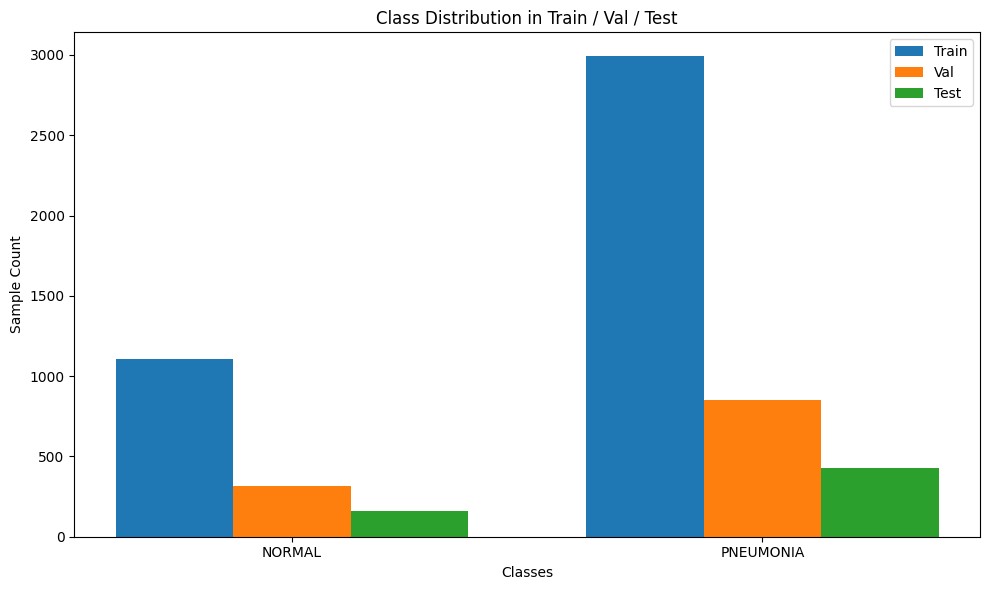

In [4]:
# Load labels
csv_path = '/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/labels.csv'
df = pd.read_csv(csv_path)

# Map labels to integers
label_map = {'NORMAL': 0, 'PNEUMONIA-VIRAL': 1, 'PNEUMONIA-BACTERIAL': 1}
df['label_idx'] = df['label'].map(label_map)
class_names = ['NORMAL', 'PNEUMONIA']
n_classes = len(class_names)

# Use same split indices
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]
test_df = df.iloc[test_idx]

# Count labels per split
train_counts = train_df['label_idx'].value_counts().sort_index()
val_counts = val_df['label_idx'].value_counts().sort_index()
test_counts = test_df['label_idx'].value_counts().sort_index()

# Plot class distribution
indices = np.arange(len(class_names))
bar_width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(indices - bar_width, train_counts, width=bar_width, label='Train')
plt.bar(indices, val_counts, width=bar_width, label='Val')
plt.bar(indices + bar_width, test_counts, width=bar_width, label='Test')

plt.xticks(indices, class_names)
plt.xlabel('Classes')
plt.ylabel('Sample Count')
plt.title('Class Distribution in Train / Val / Test')
plt.legend()
plt.tight_layout()
plt.show()

## Sample Images from Training Set

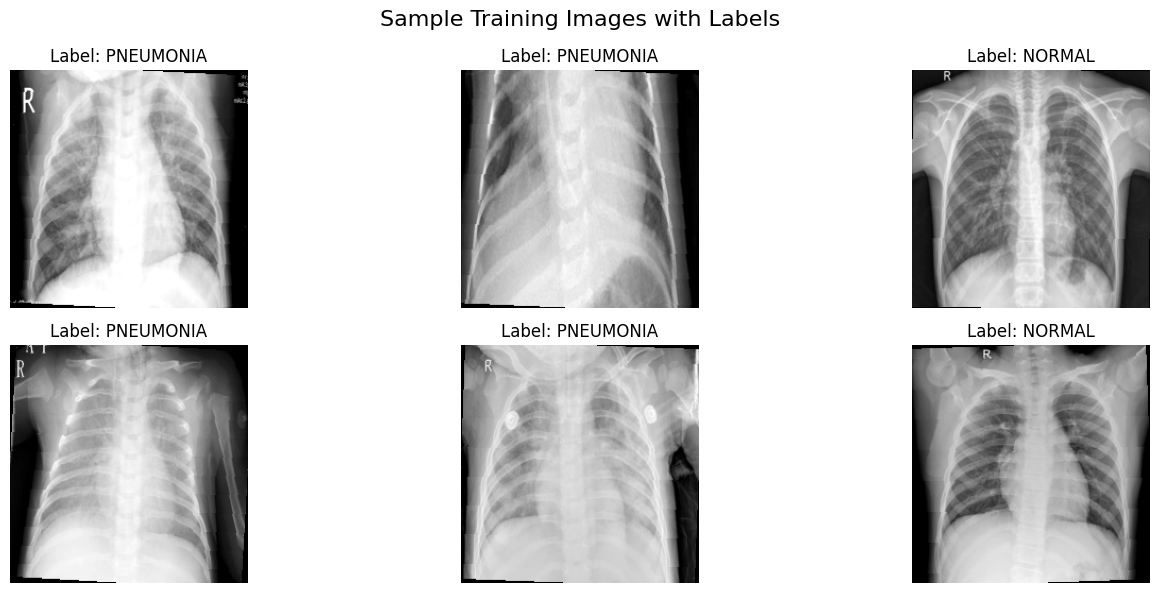

In [5]:
# Corrected reverse mapping
idx_to_class = {i: name for i, name in enumerate(class_names)}

# Get a few samples from training data
num_samples = 6
samples = [train_data[i] for i in range(num_samples)]

# Plot the images
plt.figure(figsize=(15, 6))
for i, (img_tensor, label) in enumerate(samples):
    img = img_tensor.squeeze().numpy()
    if img.ndim == 3:
        img = img.transpose(1, 2, 0)  # (C, H, W) → (H, W, C)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
    plt.title(f"Label: {idx_to_class[int(label)]}")
    plt.axis('off')

plt.suptitle("Sample Training Images with Labels", fontsize=16)
plt.tight_layout()
plt.show()

## Model Architecture
Custom CNN model `PneuNet` defined using pytorch `nn.Module` consisting of 4 convolutional blocks, an adaptive average pooling layer and two fully connected layers. The final layer output is a single login for binary classification.

In [4]:
class PneuNet(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int = 64, dropout_p=0.3):
        """
        Initializes the PneuNet model.

        Parameters:
        - input_shape (int): Number of input channels
        - hidden_units (int): Number of filters to start with in the first conv layer
        - dropout_p (float): Dropout probability used after each pooling layer
        """
        super(PneuNet, self).__init__()

        self.features = nn.Sequential(

            # Block 1: Input → 64 filters → Downsample
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 224 → 112
            nn.Dropout2d(dropout_p),

            # Block 2: 128 filters → Downsample
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112 → 56
            nn.Dropout2d(dropout_p),

            # Block 3: 256 filters → Downsample
            nn.Conv2d(hidden_units * 2, hidden_units * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_units * 4, hidden_units * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56 → 28
            nn.Dropout2d(dropout_p),

            # Block 4: 512 filters → Downsample
            nn.Conv2d(hidden_units * 4, hidden_units * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 8),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_units * 8, hidden_units * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28 → 14
            nn.Dropout2d(dropout_p),
        )

        # Fully connected classifier head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),       # Global pooling
            nn.Flatten(),                       # Flatten
            nn.Linear(hidden_units * 8, 128),   # Dense layer
            nn.ReLU(inplace=True),              # ReLU activation
            nn.Dropout(dropout_p),              # Dropout for regularization
            nn.Linear(128, 1)                   # Output single logit for binary classification
        )

    # Forward pass function
    def forward(self, x):
        x = self.features(x)      # Pass through convolutional blocks
        x = self.classifier(x)    # Pass through fc head
        return x

## Calculate Class Weight for Weighted Binary Crossentropy Loss

In [6]:
# Read CSV file with filenames and labels
df = pd.read_csv('/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/labels.csv')
label_map = {'NORMAL': 0, 'PNEUMONIA-VIRAL': 1, 'PNEUMONIA-BACTERIAL': 1}
df['label_idx'] = df['label'].map(label_map)

# Get training labels
train_labels = df.iloc[train_idx]['label'].map(label_map).tolist()
# Count types of samples
counts = Counter(train_labels)
# Get positive class weight to use with BCE loss
pos_weight = torch.tensor([counts[0] / counts[1]], dtype=torch.float32).to(device)

## Model Training and Evaluation Functions
Define model, loss function and optimizer. Define `train_model` training loop to perform training and validation, and save the model checkpoint that achieves the best validation loss.

Define `evaluate_model` function to assess model performance on test data. Perform forward passes in evaluation mode and compute class probabilities using a sigmoid activation. Threshold is determined with optimization. Output includes a classification report and a confusion matrix.

In [7]:
# Initiatie model with 1 input channela and 128 base filters
model = model = PneuNet(input_shape=1, hidden_units=128).to(device)
# Weighted BCE loss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Model training function
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=30):
    model.to(device)  # Send model to GPU
    best_val_loss = float("inf")   # Initialize best loss tracker

    # Lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Iterate through epochs
    for epoch in range(epochs):
        model.train()   # Training mode
        train_loss, train_correct = 0, 0
        total_train = 0

        print(f"\nEpoch {epoch+1}/{epochs}")
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for X, y in train_bar:
            X, y = X.to(device), y.float().unsqueeze(1).to(device)  # shape: [B], y values ∈ {0,1,2}

            optimizer.zero_grad()         # Clear gradients
            y_pred = model(X)             # Get predictions
            loss = criterion(y_pred, y)   # Loss
            loss.backward()               # Backpropagation
            optimizer.step()              # Update weights

            # Accumulate loss and accuracy
            train_loss += loss.item() * X.size(0)
            preds = (torch.sigmoid(y_pred) > 0.5).float()
            train_correct += (preds == y).sum().item()
            total_train += y.size(0)

            train_bar.set_postfix(loss=loss.item())

        # Get average training loss and accuracy
        epoch_train_loss = train_loss / total_train
        epoch_train_acc = train_correct / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        model.eval()  # Validation mode
        val_loss, val_correct, total_val = 0, 0, 0

        val_bar = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for X, y in val_bar:
                X, y = X.to(device), y.float().unsqueeze(1).to(device)
                y_pred = model(X)
                loss = criterion(y_pred, y)

                val_loss += loss.item() * X.size(0)
                preds = (torch.sigmoid(y_pred) > 0.5).float()
                val_correct += (preds == y).sum().item()
                total_val += y.size(0)

        # Get average validation loss and accuracy
        epoch_val_loss = val_loss / total_val
        epoch_val_acc = val_correct / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch+1}: Train Loss = {epoch_train_loss:.4f}, Acc = {epoch_train_acc:.4f} | Val Loss = {epoch_val_loss:.4f}, Acc = {epoch_val_acc:.4f}")

        # Save model if best so far
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), "/content/drive/MyDrive/bds_pneumoniamnist_model_custom.pth")
            print("✅ Saved best model.")

    # Return metrics
    return {
        "train_loss": train_losses,
        "train_acc": train_accuracies,
        "val_loss": val_losses,
        "val_acc": val_accuracies
    }


# Model evaluation function
def evaluate_model(model, test_loader, device, class_names):
    model.eval()  # Testing mode
    model.to(device)

    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            probs = torch.sigmoid(logits)   # Logits to probabilities
            preds = (probs > 0.0880).int().cpu()    # Use optimized threshold
            all_preds.append(preds)
            all_labels.append(y.cpu())

    # Concatenate
    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()

    # Classification report
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues")

    return y_true, y_pred

## Model Summary and ONNX Export
Get detailed summary of model architecture and export `pneunet_architecture.onnx` file to be opened in Netron to generate architecture diagram.

In [10]:
summary(model, input_size=(1, 128, 128))
dummy_input = torch.randn(1, 1, 128, 128).to(device)
torch.onnx.export(
    model,  # Model
    dummy_input,  # Dummy input
    "/content/drive/MyDrive/pneunet_architecture.onnx",  # Get ONNX file
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 117.5 MB/s eta 0:00:00
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 128, 128]           1,280
       BatchNorm2d-2        [-1, 128, 128, 128]             256
              ReLU-3        [-1, 128, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]         147,584
       BatchNorm2d-5        [-1, 128, 128, 128]             256
              ReLU-6        [-1, 128, 128, 128]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
         Dropout2d-8          [-1, 128, 64, 64]               0
            Conv2d-9          [-1, 256, 64, 64]         295,168
      BatchNorm2d-10          [-1, 256, 64, 64]             512
             ReLU-11          [-1, 256, 64, 64]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
      BatchNorm2d-13   

## Train and Save Model

In [ ]:
history = train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=25)


Epoch 1/25


Epoch 1: Train Loss = 0.2965, Acc = 0.7185 | Val Loss = 0.8217, Acc = 0.7293
✅ Saved best model.

Epoch 2/25


Epoch 2: Train Loss = 0.2343, Acc = 0.7948 | Val Loss = 0.3261, Acc = 0.8275
✅ Saved best model.

Epoch 3/25


Epoch 3: Train Loss = 0.2126, Acc = 0.8212 | Val Loss = 0.1904, Acc = 0.8898
✅ Saved best model.

Epoch 4/25


Epoch 4: Train Loss = 0.2003, Acc = 0.8351 | Val Loss = 0.2099, Acc = 0.8941

Epoch 5/25


Epoch 5: Train Loss = 0.1903, Acc = 0.8485 | Val Loss = 0.2308, Acc = 0.8907

Epoch 6/25


Epoch 6: Train Loss = 0.1756, Acc = 0.8590 | Val Loss = 0.1367, Acc = 0.8873
✅ Saved best model.

Epoch 7/25


Epoch 7: Train Loss = 0.1582, Acc = 0.8780 | Val Loss = 0.1333, Acc = 0.8847
✅ Saved best model.

Epoch 8/25


Epoch 8: Train Loss = 0.1507, Acc = 0.8802 | Val Loss = 0.1198, Acc = 0.8967
✅ Saved best model.

Epoch 9/25


Epoch 9: Train Loss = 0.1482, Acc = 0.8844 | Val Loss = 0.1153, Acc = 0.9112
✅ Saved best model.

Epoch 10/25


Epoch 10: Train Loss = 0.1384, Acc = 0.8931 | Val Loss = 0.1146, Acc = 0.9274
✅ Saved best model.

Epoch 11/25


Epoch 11: Train Loss = 0.1370, Acc = 0.8970 | Val Loss = 0.1125, Acc = 0.9266
✅ Saved best model.

Epoch 12/25


Epoch 12: Train Loss = 0.1278, Acc = 0.8985 | Val Loss = 0.1038, Acc = 0.9317
✅ Saved best model.

Epoch 13/25


Epoch 13: Train Loss = 0.1306, Acc = 0.9010 | Val Loss = 0.1085, Acc = 0.9334

Epoch 14/25


Epoch 14: Train Loss = 0.1265, Acc = 0.9022 | Val Loss = 0.1028, Acc = 0.9120
✅ Saved best model.

Epoch 15/25


Epoch 15: Train Loss = 0.1236, Acc = 0.9066 | Val Loss = 0.1047, Acc = 0.9436

Epoch 16/25


Epoch 16: Train Loss = 0.1219, Acc = 0.9095 | Val Loss = 0.0952, Acc = 0.9385
✅ Saved best model.

Epoch 17/25


Epoch 17: Train Loss = 0.1175, Acc = 0.9134 | Val Loss = 0.0927, Acc = 0.9325
✅ Saved best model.

Epoch 18/25


Epoch 18: Train Loss = 0.1169, Acc = 0.9149 | Val Loss = 0.0960, Acc = 0.9266

Epoch 19/25


Epoch 19: Train Loss = 0.1136, Acc = 0.9151 | Val Loss = 0.0892, Acc = 0.9436
✅ Saved best model.

Epoch 20/25


Epoch 20: Train Loss = 0.1140, Acc = 0.9188 | Val Loss = 0.0959, Acc = 0.9471

Epoch 21/25


Epoch 21: Train Loss = 0.1081, Acc = 0.9229 | Val Loss = 0.1064, Acc = 0.9035

Epoch 22/25


Epoch 22: Train Loss = 0.1121, Acc = 0.9166 | Val Loss = 0.1044, Acc = 0.8958

Epoch 23/25


Epoch 23: Train Loss = 0.1086, Acc = 0.9173 | Val Loss = 0.1006, Acc = 0.9120

Epoch 24/25


Epoch 24: Train Loss = 0.1040, Acc = 0.9185 | Val Loss = 0.0856, Acc = 0.9385
✅ Saved best model.

Epoch 25/25


Epoch 25: Train Loss = 0.1001, Acc = 0.9271 | Val Loss = 0.0844, Acc = 0.9325
✅ Saved best model.


## Save Training Log and Display Training History

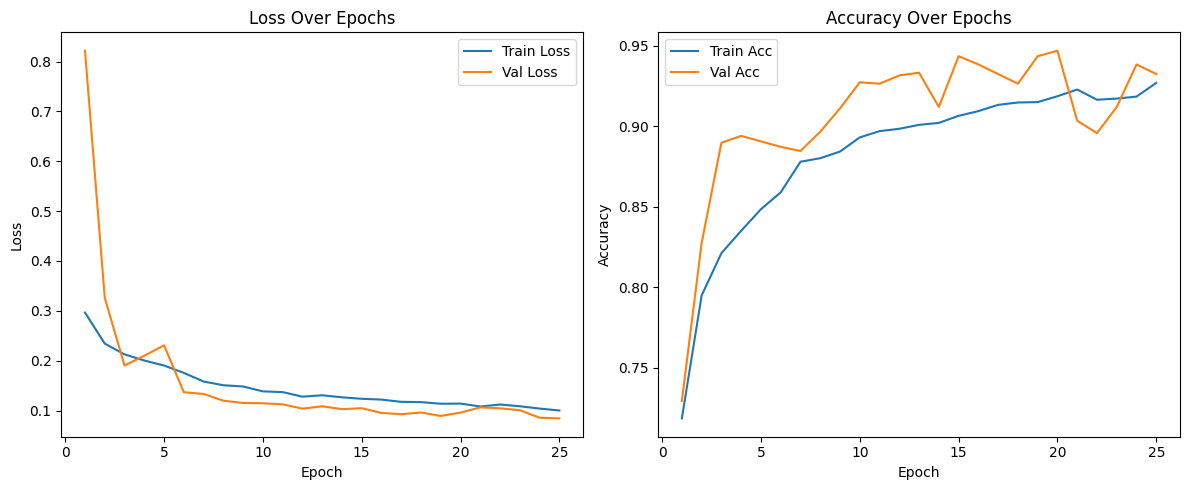

In [ ]:
# Convert history to df
history_df = pd.DataFrame(history)
# Save to CSV
history_df.to_csv('/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/pneumoniamnist_training_history.csv', index=False)

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

## Load and Evaluate Best Model

              precision    recall  f1-score   support

      NORMAL       0.92      0.89      0.90       158
   PNEUMONIA       0.96      0.97      0.97       428

    accuracy                           0.95       586
   macro avg       0.94      0.93      0.93       586
weighted avg       0.95      0.95      0.95       586



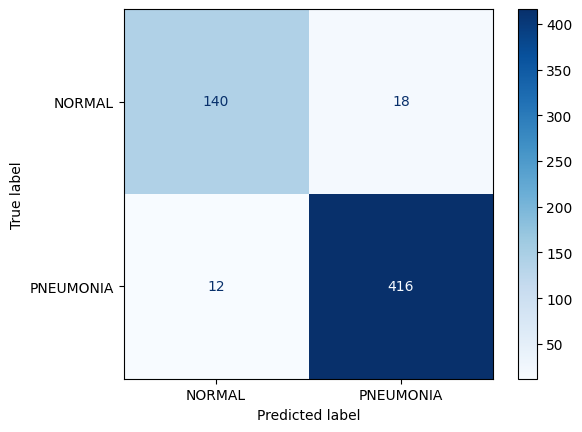

In [10]:
# Load and evaluate best model
model.load_state_dict(torch.load("/content/drive/MyDrive/bds_pneumoniamnist_model_custom.pth"))
y_true, y_pred = evaluate_model(model, test_dataloader, device, class_names)

## Threshold Optimization and ROC Analysis
Identify the optimal classification threshold. While the default threshold in binary classification is 0.5, models trained on imbalanced data often benefit from a custom threshold that balances **recall**, **precision**, and **F1 score** more effectively.

Test thresholds between 0.5 and 0.95. Maximize a custom score made up of **F1 score** (balance of precision and recall) and **Recall** (sensitivity to pneumonia) to emphasize pneumonia detection and place a stronger influence on minimizing false negtives.

$\text{Custom Score} = \frac{1}{2} (\text{F1 Score}) + \frac{1}{2} (\text{Recall})$

Calculate ROC AUC scores to ensure the model's ability to distinguish between classes regardless of threshold.

Displays ROC Curve and Threshold vs. Score plot.

ROC AUC: 0.9841
Best Threshold: 0.0880


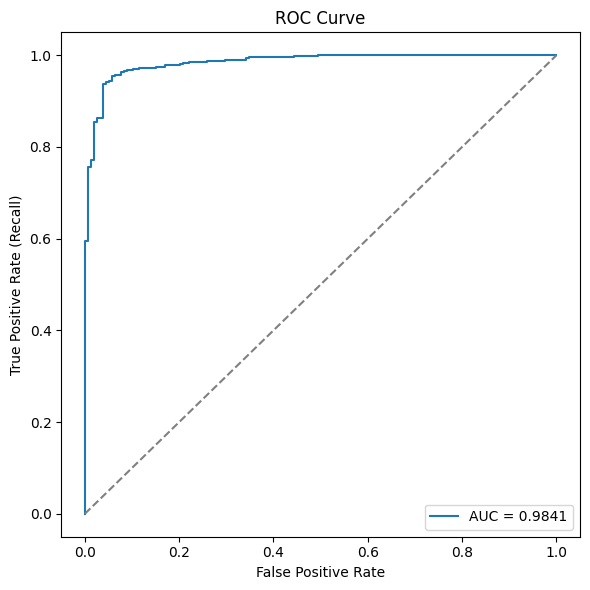

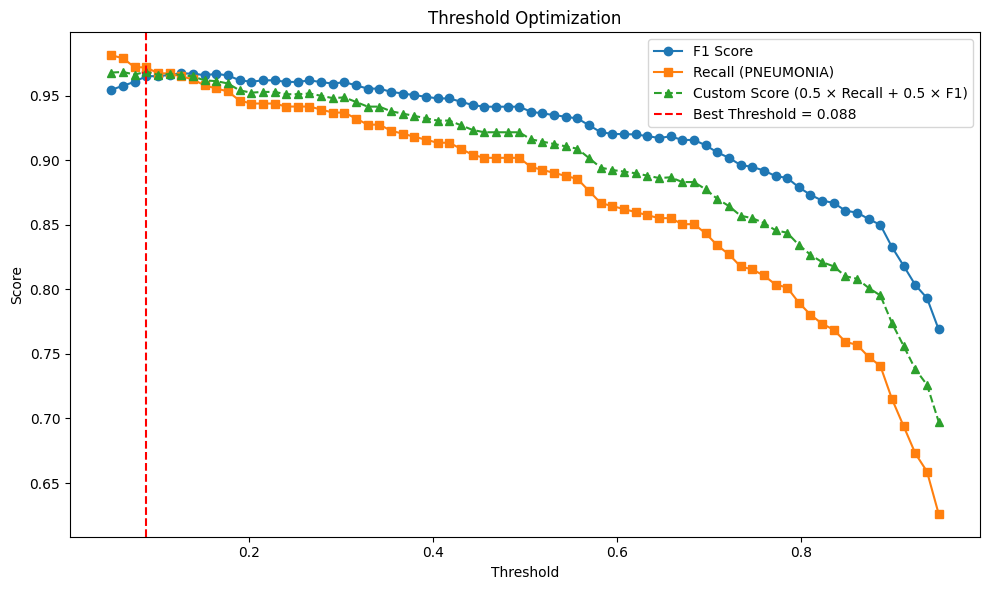

In [11]:
# Function to evaluate thresholds
def evaluate_thresholds(model, test_loader, device, thresholds=np.linspace(0.05, 0.95, 30)):
    model.eval()      # Testing mode
    model.to(device)

    # Lists to store predicted probabilities and true binary labels
    all_probs = []
    all_labels = []

    # Get all probabilities and true labels
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            probs = torch.sigmoid(logits).squeeze().cpu().numpy()
            labels = y.cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Convert to numpy array
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Compute ROC AUC
    roc_auc = roc_auc_score(all_labels, all_probs)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Initialize variables and lists for tracking
    best_score = 0
    best_threshold = 0
    custom_scores = []
    recall_scores = []
    f1_scores = []

    # Iterate throuhg tested thresholds
    for thresh in thresholds:
        preds = (all_probs > thresh).astype(int)
        # Get F1 and recall for threshold
        f1 = f1_score(all_labels, preds)
        recall = recall_score(all_labels, preds)  # Pneumonia recall

        # Custom score
        custom = 0.5 * recall + 0.5 * f1

        # Store metrics
        custom_scores.append(custom)
        recall_scores.append(recall)
        f1_scores.append(f1)

        # Update best threhold if necessary
        if custom > best_score:
            best_score = custom
            best_threshold = thresh

    print(f"Best Threshold: {best_threshold:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot F1 vs threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, label="F1 Score", marker='o')
    plt.plot(thresholds, recall_scores, label="Recall (PNEUMONIA)", marker='s')
    plt.plot(thresholds, custom_scores, label="Custom Score (0.5 × Recall + 0.5 × F1)", linestyle='--', marker='^')

    # Highlight the best threshold
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.3f}')
    plt.scatter([best_threshold], [best_score], color='red')

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Threshold Optimization")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_threshold, all_probs, all_labels

thresholds = np.linspace(0.05, 0.95, 72)
best_thresh, probs, labels = evaluate_thresholds(model, test_dataloader, device, thresholds)

## Extract and Save Test Images:
* As full-sized images for analysis
* As thumbnail images for compact display



In [13]:
# Copy test images to a new folder and make thumbnails
test_image_dir = "/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/test_images_full"
thumbnail_dir = "/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/test_images_thumbnails"
os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(thumbnail_dir, exist_ok=True)

for i in range(len(test_data)):
    img_tensor, label = test_data[i]
    img_name = f"test_img_{i:04d}.png"
    label_name = "PNEUMONIA" if label == 1 else "NORMAL"

    # Save original
    img = transforms.ToPILImage()(img_tensor)
    img.save(os.path.join(test_image_dir, img_name))

    # Save thumbnail
    img_thumb = img.copy()
    img_thumb.thumbnail((100, 100))
    img_thumb.save(os.path.join(thumbnail_dir, img_name))

## Grad-CAM Visualization and Prediction Logging
Create a folder to store Grad-CAM images, and define the last convolutional layer as the target layer.

For each image:
* Classify image
* Use Grad-CAM to highlight regions most influential to the model's decision
* Convert to RGB colormap and save Grad-CAM image
* Save all relevant information:
  - Filename
  - True and predicted labels
  - Probability score
  - Used Threshold (0.0880 for all)
  - Path to Grad-CAM image

The Grad-CAM helps interpret the model's reasoning by highlighting important regions. The CSV lets the Streamlit app load precomputed results instantly without rerunning the model. It ensures reproducibility and transparency in model evaluation.

In [19]:
# Setup paths
gradcam_dir = "/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/Gradcam images"
os.makedirs(gradcam_dir, exist_ok=True)

# Target layer for Grad-CAM
target_layers = [model.features[-3]]
cam = GradCAM(model=model, target_layers=target_layers)
model.to(device).eval()

# Label mapping
label_map = {
    'NORMAL': 0,
    'PNEUMONIA-VIRAL': 1,
    'PNEUMONIA-BACTERIAL': 1
}
int_to_name = {0: 'NORMAL', 1: 'PNEUMONIA'}

# List to store records
csv_records = []

# Loop through test data
for i in tqdm(range(len(test_data))):
    X, y = test_data[i]
    X = X.unsqueeze(0).to(device)
    X.requires_grad_()

    # Model prediction
    logits = model(X)
    prob = torch.sigmoid(logits).item()
    y_pred = int(prob > 0.0880)  # Based on optimization
    y_true = int(y)

    # Grad-CAM
    grayscale_cam = cam(input_tensor=X)[0, :]
    gray_np = X.squeeze().detach().cpu().numpy()
    rgb_img = np.stack([gray_np]*3, axis=-1)
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-8)
    cam_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Save Grad-CAM image
    gradcam_path = os.path.join(gradcam_dir, f"test_gradcam_{i:04d}.png")
    Image.fromarray(cam_img).save(gradcam_path)

    # Save record
    csv_records.append({
        "filename": f"test_img_{i:04d}.png",
        "true_label": y_true,
        "true_label_name": int_to_name[y_true],
        "predicted_label": y_pred,
        "predicted_label_name": int_to_name[y_pred],
        "probability": round(prob, 4),
        "threshold_used": threshold,
        "gradcam_path": gradcam_path
    })

# Save to CSV
df_preds = pd.DataFrame(csv_records)
df_preds.to_csv("/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/labels_and_predictions.csv", index=False)

100%|██████████| 586/586 [00:42<00:00, 13.82it/s]
